In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
import io
df = pd.read_csv('/content/hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [3]:
print(df.shape)
print(df['label'].value_counts())

(25675, 64)
label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: int64


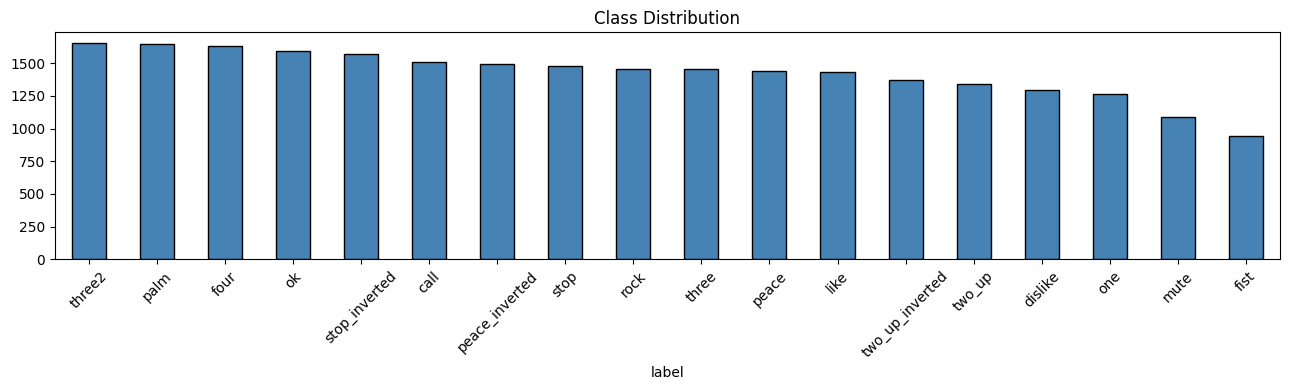

In [4]:
df['label'].value_counts().plot(kind='bar', figsize=(13, 4), color='steelblue', edgecolor='black')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150)
plt.show()

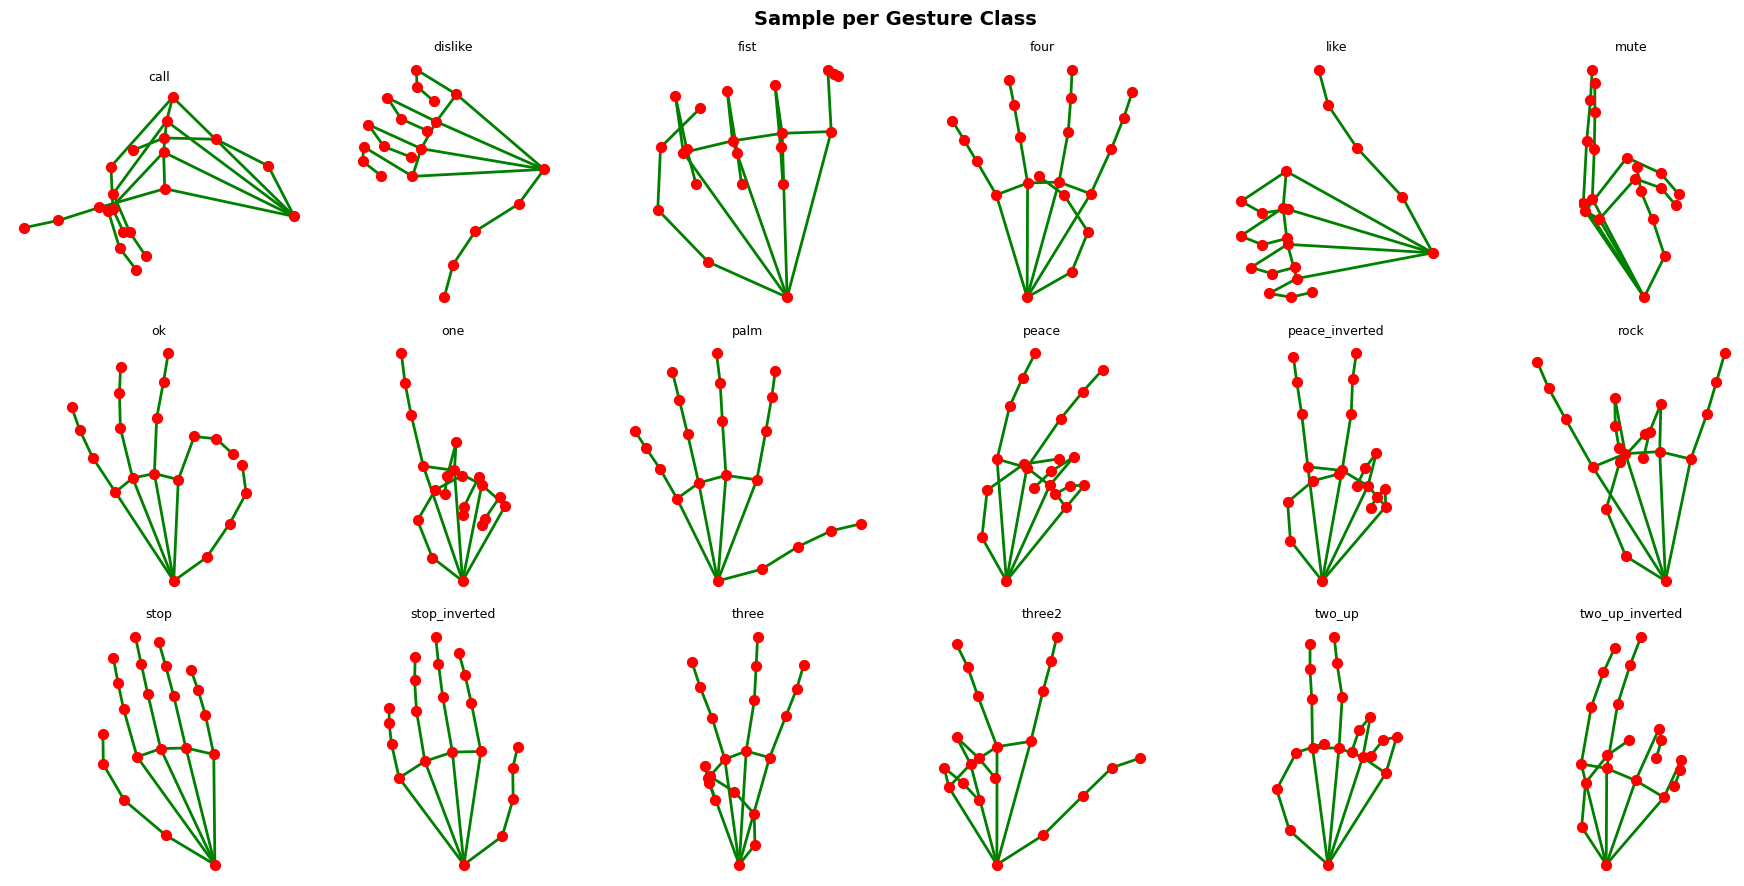

In [5]:
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (0,9),(9,10),(10,11),(11,12),
    (0,13),(13,14),(14,15),(15,16),
    (0,17),(17,18),(18,19),(19,20),
    (5,9),(9,13),(13,17)
]

def plot_hand(row, title='', ax=None):
    show = ax is None
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    x = [row[f'x{i}'] for i in range(1, 22)]
    y = [row[f'y{i}'] for i in range(1, 22)]
    for a, b in HAND_CONNECTIONS:
        ax.plot([x[a], x[b]], [y[a], y[b]], 'g-', linewidth=2)
    ax.scatter(x, y, c='red', s=50, zorder=2)
    ax.set_title(title, fontsize=9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')
    if show:
        plt.tight_layout()
        plt.show()

gesture_classes = sorted(df['label'].unique())
cols = 6
rows = (len(gesture_classes) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

for i, g in enumerate(gesture_classes):
    sample = df[df['label'] == g].iloc[0]
    plot_hand(sample, title=g, ax=axes[i])

for j in range(len(gesture_classes), len(axes)):
    axes[j].axis('off')

plt.suptitle('Sample per Gesture Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('hand_landmarks_per_class.png', dpi=150)
plt.show()

In [6]:
def normalize(df):
    df = df.copy()
    for idx in df.index:
        wx, wy = df.loc[idx, 'x1'], df.loc[idx, 'y1']
        for i in range(1, 22):
            df.loc[idx, f'x{i}'] -= wx
            df.loc[idx, f'y{i}'] -= wy
        scale = np.sqrt(df.loc[idx, 'x13']**2 + df.loc[idx, 'y13']**2)
        if scale > 1e-6:
            for i in range(1, 22):
                df.loc[idx, f'x{i}'] /= scale
                df.loc[idx, f'y{i}'] /= scale
    return df

df_norm = normalize(df)
df_norm.dropna(inplace=True)
df_norm.reset_index(drop=True, inplace=True)

In [8]:
feature_cols = [c for c in df_norm.columns if c != 'label']
X = df_norm[feature_cols].values

le = LabelEncoder()
y = le.fit_transform(df_norm['label'])
class_names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [9]:
import time

def train_eval(name, model, Xtr, ytr, Xte, yte):
    t = time.time()
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    return {
        'Model':     name,
        'Accuracy':  accuracy_score(yte, pred),
        'Precision': precision_score(yte, pred, average='weighted', zero_division=0),
        'Recall':    recall_score(yte, pred, average='weighted', zero_division=0),
        'F1':        f1_score(yte, pred, average='weighted', zero_division=0),
        'Time':      round(time.time() - t, 2),
        '_pred':     pred,
        '_model':    model,
    }

results = []
preds = {}

rf  = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1)
mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=300, random_state=42, early_stopping=True)

for name, model, Xtr, Xte in [
    ('Random Forest', rf,  X_train,    X_test),
    ('SVM',           svm, X_train_sc, X_test_sc),
    ('KNN',           knn, X_train_sc, X_test_sc),
    ('MLP',           mlp, X_train_sc, X_test_sc),
]:
    r = train_eval(name, model, Xtr, y_train, Xte, y_test)
    results.append(r)
    preds[name] = r['_pred']
    print(f"{name}: Acc={r['Accuracy']:.4f}, F1={r['F1']:.4f}, Time={r['Time']}s")

Random Forest: Acc=0.9792, F1=0.9792, Time=36.2s
SVM: Acc=0.9698, F1=0.9699, Time=8.71s
KNN: Acc=0.9369, F1=0.9370, Time=0.8s
MLP: Acc=0.9875, F1=0.9875, Time=22.12s


In [10]:
keys = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
results_df = pd.DataFrame([{k: r[k] for k in keys} for r in results])
results_df = results_df.sort_values('F1', ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision,Recall,F1,Time
0,MLP,0.987537,0.987673,0.987537,0.987550,22.12
1,Random Forest,0.979163,0.979361,0.979163,0.979208,36.20
2,SVM,0.969815,0.970271,0.969815,0.969870,8.71
3,KNN,0.936904,0.937804,0.936904,0.936980,0.80


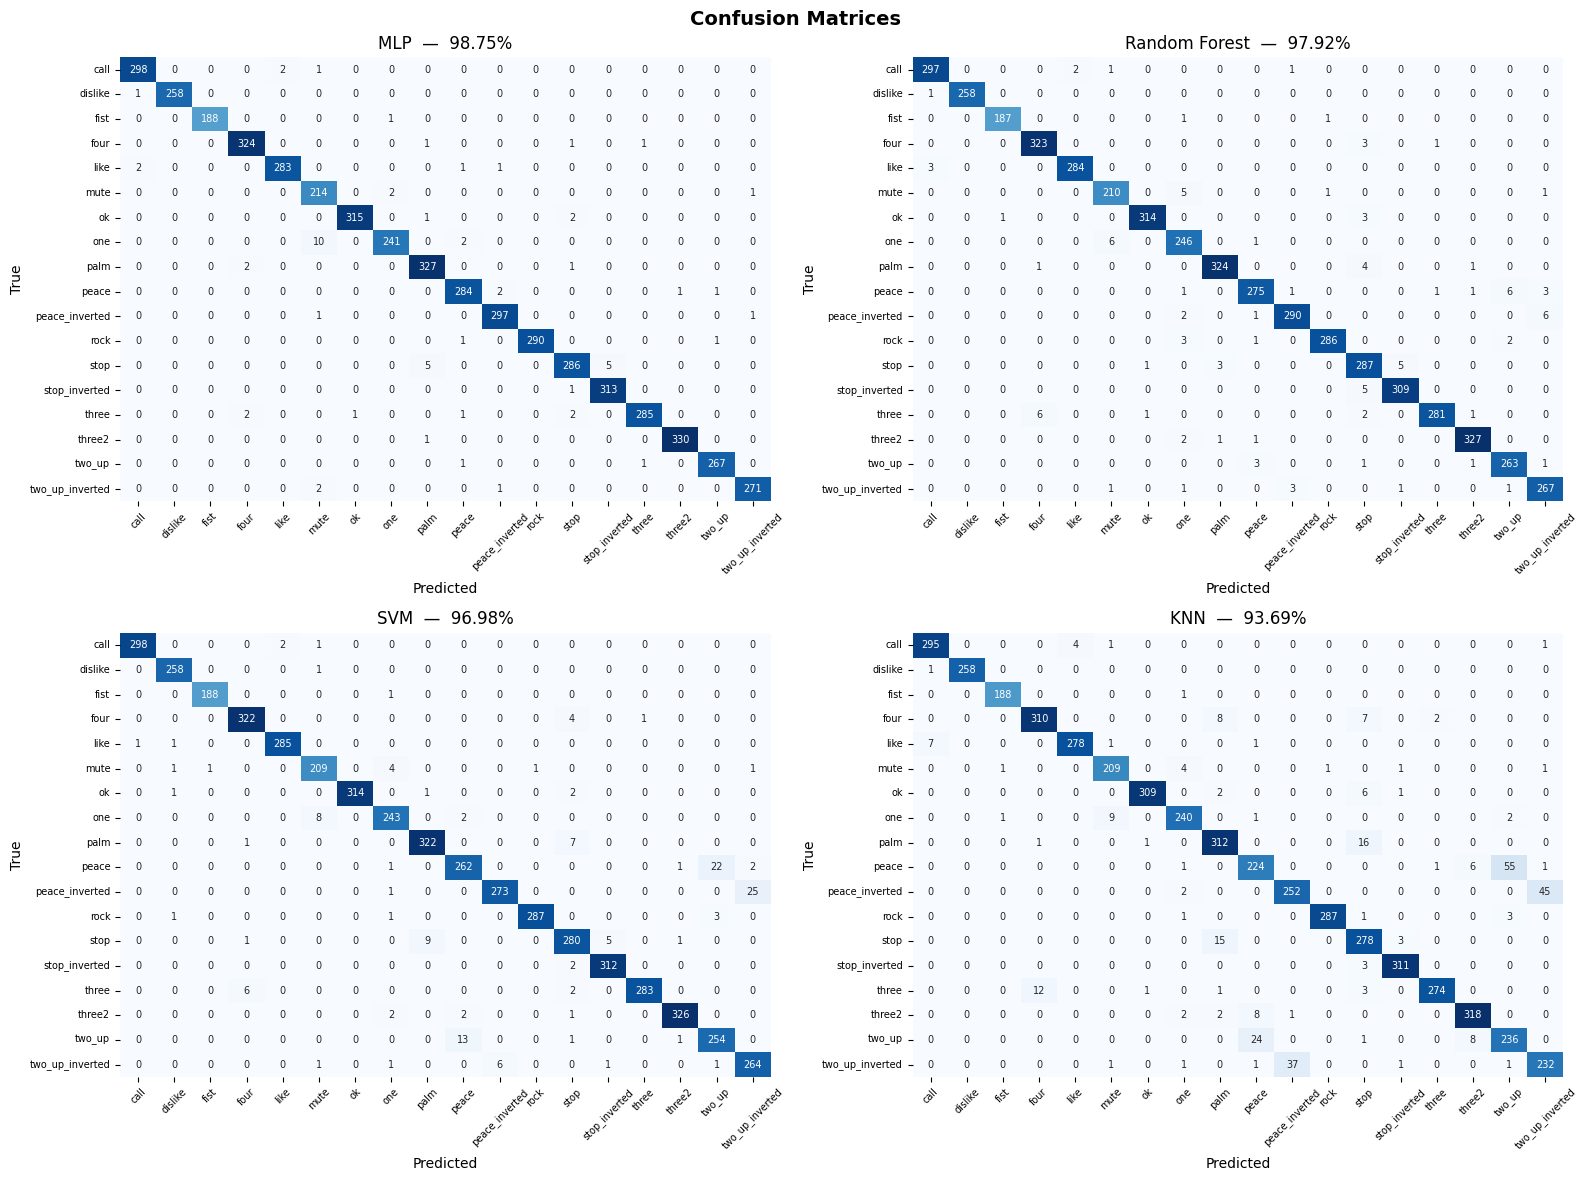

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, name in zip(axes.flatten(), results_df['Model']):
    cm = confusion_matrix(y_test, preds[name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, cbar=False, annot_kws={'size': 7})
    ax.set_title(f'{name}  —  {accuracy_score(y_test, preds[name]):.2%}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.tick_params(axis='y', rotation=0, labelsize=7)
plt.suptitle('Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150)
plt.show()

In [12]:
best_name = results_df.iloc[0]['Model']
print(f'Best model: {best_name}')
print(classification_report(y_test, preds[best_name], target_names=class_names, zero_division=0))

Best model: MLP
                 precision    recall  f1-score   support

           call       0.99      0.99      0.99       301
        dislike       1.00      1.00      1.00       259
           fist       1.00      0.99      1.00       189
           four       0.99      0.99      0.99       327
           like       0.99      0.99      0.99       287
           mute       0.94      0.99      0.96       217
             ok       1.00      0.99      0.99       318
            one       0.99      0.95      0.97       253
           palm       0.98      0.99      0.98       330
          peace       0.98      0.99      0.98       288
 peace_inverted       0.99      0.99      0.99       299
           rock       1.00      0.99      1.00       292
           stop       0.98      0.97      0.97       296
  stop_inverted       0.98      1.00      0.99       314
          three       0.99      0.98      0.99       291
         three2       1.00      1.00      1.00       331
         two_u

In [13]:
!pip install mediapipe==0.10.14

In [14]:
import cv2
import numpy as np
from collections import deque
from scipy import stats as scipy_stats
import mediapipe as mp
from mediapipe.python.solutions import hands as mp_hands_module
from mediapipe.python.solutions import drawing_utils as mp_draw

best_clf = results[next(i for i, r in enumerate(results) if r['Model'] == best_name)]['_model']
use_scale = best_name != 'Random Forest'

def normalize_realtime(lms):
    lms = np.array(lms, dtype=np.float32)
    lms[:, 0] -= lms[0, 0]
    lms[:, 1] -= lms[0, 1]
    scale = np.sqrt(lms[12, 0]**2 + lms[12, 1]**2)
    if scale > 1e-6:
        lms[:, 0] /= scale
        lms[:, 1] /= scale
    return lms.flatten()

def process_video(input_path, output_path, window=10):
    hands = mp_hands_module.Hands(max_num_hands=1, min_detection_confidence=0.5)
    cap = cv2.VideoCapture(input_path)
    fps    = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    buf = deque(maxlen=window)

    with hands:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            res = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            label = ''
            if res.multi_hand_landmarks:
                for h in res.multi_hand_landmarks:
                    mp_draw.draw_landmarks(frame, h, mp_hands_module.HAND_CONNECTIONS)
                lms = [(l.x, l.y, l.z) for l in res.multi_hand_landmarks[0].landmark]
                feat = normalize_realtime(lms).reshape(1, -1)
                if use_scale:
                    feat = scaler.transform(feat)
                buf.append(best_clf.predict(feat)[0])
                label = class_names[scipy_stats.mode(list(buf), keepdims=True).mode[0]]
            cv2.rectangle(frame, (0, 0), (280, 45), (0, 0, 0), -1)
            cv2.putText(frame, label, (10, 32), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            out.write(frame)
    cap.release()
    out.release()
    print(f'saved to {output_path}')

In [15]:
uploaded_vid = files.upload()
vid_name = list(uploaded_vid.keys())[0]
with open(f'/content/{vid_name}', 'wb') as f:
    f.write(uploaded_vid[vid_name])

process_video(f'/content/{vid_name}', '/content/output.mp4')
files.download('/content/output.mp4')

Saving Input - Made with Clipchamp.mp4 to Input - Made with Clipchamp.mp4
saved to /content/output.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import joblib
joblib.dump(best_clf, f'/content/{best_name.replace(" ","_")}.pkl')
joblib.dump(scaler, '/content/scaler.pkl')
joblib.dump(le, '/content/label_encoder.pkl')

['/content/label_encoder.pkl']